# Code to generate random incompressible flow snap-shots

In [154]:
import numpy as np
import scipy as sp1
import scipy.ndimage as sp
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models

## Parameters

In [155]:
GridSize = 100
SmoothenSigma = 20
MaxShift = 3

## Random seed-field

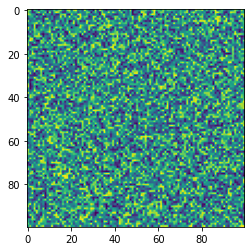

In [156]:
RandomField = np.random.rand( GridSize , GridSize )

plt.imshow( RandomField )
plt.show()

## Smooth the random field

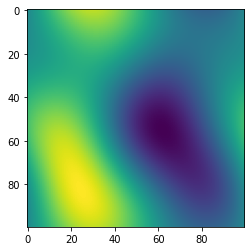

In [157]:
StreamFunction = sp.gaussian_filter( RandomField , sigma=SmoothenSigma , mode='wrap' )

plt.imshow( StreamFunction )
plt.show()

## Flow from stream function: $\psi$
### For any smooth random scalar field $\psi$, the velocity field is given by
### $ \vec{u} = \nabla \times \psi $
### such that, $\nabla . \vec{u} = 0$, i.e. incompressible.

## Calculation of velocity field

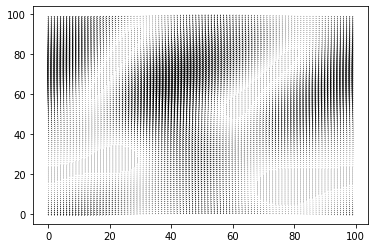

In [158]:
Vx =  np.gradient( StreamFunction , axis=0 )
Vy = -np.gradient( StreamFunction , axis=1 )

plt.quiver( Vx , Vy , units='width' )
plt.show()

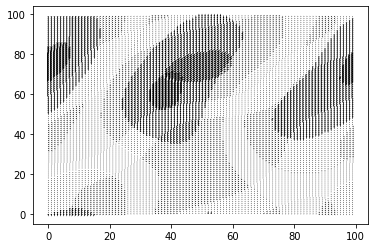

In [159]:
MagV = np.sqrt( Vx * Vx + Vy * Vy )
MaxMagV = np.max( MagV )

Vx = np.round( Vx * MaxShift / MaxMagV )
Vy = np.round( Vy * MaxShift / MaxMagV )

plt.quiver( Vx , Vy , units='width' )
plt.show()

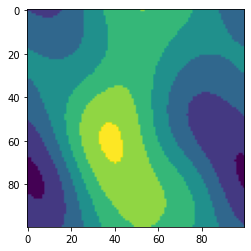

In [160]:
plt.imshow(Vy)

In [161]:
Frame1 = np.random.rand( GridSize , GridSize )
Frame2 = np.copy( Frame1 )

for XShift in range(-MaxShift , MaxShift):
    for YShift in range(-MaxShift , MaxShift):
        I = ((Vx<XShift) * (Vy==YShift))

        OverlayFrame = np.random.rand( GridSize , GridSize )

        Frame1 = Frame1 * (1-I) + OverlayFrame * I

        I = np.roll( I , XShift , axis=0 )
        I = np.roll( I , YShift , axis=1 )

        OverlayFrame = np.roll( OverlayFrame , YShift , axis=0 )
        OverlayFrame = np.roll( OverlayFrame , XShift , axis=1 )

        Frame2 = Frame2 * (1-I) + OverlayFrame * I

In [162]:
Frame1 = np.random.rand( GridSize , GridSize )
Frame2 = np.copy( Frame1 )

YShift = 0

for XShift in range(-MaxShift , MaxShift):
    I = ((Vx>XShift))

    OverlayFrame = np.random.rand( GridSize , GridSize )

    Frame1 = Frame1 * (1-I) + OverlayFrame * I

    I = np.roll( I , XShift , axis=0 )
    I = np.roll( I , YShift , axis=1 )

    OverlayFrame = np.roll( OverlayFrame , YShift , axis=0 )
    OverlayFrame = np.roll( OverlayFrame , XShift , axis=1 )

    Frame2 = Frame2 * (1-I) + OverlayFrame * I

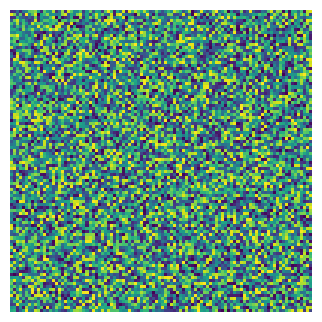

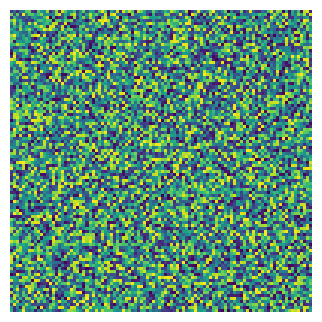

In [163]:
fig = plt.figure(figsize=(4,4), dpi=100)
plt.imshow( Frame1 )
plt.axis('off')
plt.savefig('Frame1.png',bbox_inches='tight',transparent=False,pad_inches = 0)

fig = plt.figure(figsize=(4,4), dpi=100)
plt.imshow( Frame2 )
plt.axis('off')
plt.savefig('Frame2.png',bbox_inches='tight',transparent=False,pad_inches = 0)

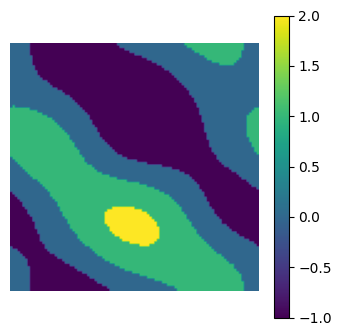

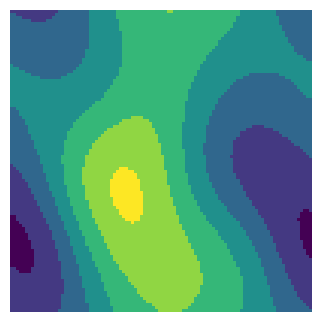

In [164]:
fig = plt.figure(figsize=(4,4), dpi=100)
plt.imshow( Vx )
plt.colorbar()
plt.axis('off')
plt.savefig('Vx.png',bbox_inches='tight',transparent=False,pad_inches = 0)

fig = plt.figure(figsize=(4,4), dpi=100)
plt.imshow( Vy )
plt.axis('off')
plt.savefig('Vy.png',bbox_inches='tight',transparent=False,pad_inches = 0)

In [165]:
DataSize = 100000
WindowSize = 12
LabelSize = 2*MaxShift + 1

Height, Width = Frame1.shape
HalfWindowSize = int( WindowSize/2 )

TrainImages = np.zeros([DataSize,WindowSize,WindowSize,2])
TrainLabels = np.zeros([DataSize,LabelSize*LabelSize])

Label = np.zeros([LabelSize,LabelSize])

In [166]:
for i in range(DataSize):
    XShift = int( np.floor( np.random.rand(1) * Width ) )
    YShift = int( np.floor( np.random.rand(1) * Height ) )

    XXShift = int( np.floor( np.random.rand(1) * 2*MaxShift ) ) - MaxShift
    YYShift = int( np.floor( np.random.rand(1) * 2*MaxShift ) ) - MaxShift

    ShiftedFrame1 = np.roll( Frame1 , (YShift,XShift) , axis=(0,1) )
    ShiftedFrame2 = np.roll( Frame1 , (YShift+YYShift,XShift+XXShift) , axis=(0,1) )

    TrainImages[i,:,:,0] = ShiftedFrame1[0:WindowSize,0:WindowSize]
    TrainImages[i,:,:,1] = ShiftedFrame2[0:WindowSize,0:WindowSize]

    Label[:,:]=0
    Label[MaxShift + YYShift,MaxShift + XXShift] = 1
    # Label[MaxShift + YYShift,:] = 1

    TrainLabels[i,:] = Label.flatten()

In [167]:
TestImages = np.zeros([DataSize,WindowSize,WindowSize,2])
TestLabels = np.zeros([DataSize,LabelSize*LabelSize])

In [168]:
for i in range(DataSize):
    XShift = int( np.floor( np.random.rand(1) * Width ) )
    YShift = int( np.floor( np.random.rand(1) * Height ) )

    XXShift = int( np.floor( np.random.rand(1) * 2*MaxShift ) ) - MaxShift
    YYShift = int( np.floor( np.random.rand(1) * 2*MaxShift ) ) - MaxShift

    ShiftedFrame1 = np.roll( Frame1 , (YShift,XShift) , axis=(0,1) )
    ShiftedFrame2 = np.roll( Frame1 , (YShift+YYShift,XShift+XXShift) , axis=(0,1) )

    TestImages[i,:,:,0] = ShiftedFrame1[0:WindowSize,0:WindowSize]
    TestImages[i,:,:,1] = ShiftedFrame2[0:WindowSize,0:WindowSize]

    Label[:,:]=0
    Label[MaxShift + YYShift,MaxShift + XXShift] = 1
    # Label[MaxShift + YYShift,:] = 1

    TestLabels[i,:] = Label.flatten()

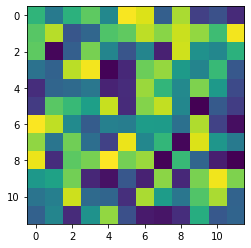

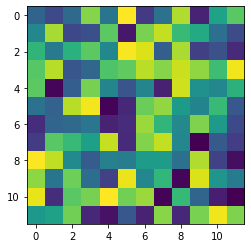

0.0


In [169]:
plt.imshow(TrainImages[10,:,:,0])
plt.show()

plt.imshow(TrainImages[10,:,:,1])
plt.show()

print(TrainLabels[10,0])

In [170]:
model = models.Sequential()

model.add( layers.Conv2D( filters=64 , kernel_size=3 , strides=(1, 1) , activation='relu' , input_shape=(WindowSize, WindowSize, 2)) )

model.add(layers.MaxPooling2D((2, 2)))

model.add( layers.Conv2D( filters=64 , kernel_size=3 , strides=(1, 1) , activation='relu' ) )

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense( LabelSize*LabelSize , activation='sigmoid'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 10, 10, 64)        1216      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 3, 3, 64)          36928     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 1, 1, 64)         0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 64)               

In [171]:
model.compile( optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

history = model.fit(TrainImages, TrainLabels, epochs=300, 
                    validation_data=(TestImages, TestLabels))

Epoch 1/300
3125/3125 [==============================] - 14s 4ms/step - loss: 0.0197 - accuracy: 0.1168 - val_loss: 0.0151 - val_accuracy: 0.3282
Epoch 2/300
3125/3125 [==============================] - 12s 4ms/step - loss: 0.0121 - accuracy: 0.4846 - val_loss: 0.0097 - val_accuracy: 0.6171
Epoch 3/300
3125/3125 [==============================] - 12s 4ms/step - loss: 0.0078 - accuracy: 0.6799 - val_loss: 0.0065 - val_accuracy: 0.7180
Epoch 4/300
3125/3125 [==============================] - 12s 4ms/step - loss: 0.0063 - accuracy: 0.7240 - val_loss: 0.0060 - val_accuracy: 0.7354
Epoch 5/300
3125/3125 [==============================] - 12s 4ms/step - loss: 0.0060 - accuracy: 0.7341 - val_loss: 0.0059 - val_accuracy: 0.7372
Epoch 6/300
3125/3125 [==============================] - 13s 4ms/step - loss: 0.0059 - accuracy: 0.7439 - val_loss: 0.0061 - val_accuracy: 0.7335
Epoch 7/300
3125/3125 [==============================] - 12s 4ms/step - loss: 0.0058 - accuracy: 0.7585 - val_loss: 0.0058 -

In [172]:
ii = 1010
np.argmax( model.predict( TrainImages[ii:(ii+1)] ) )


1/1 [==============================] - 0s 70ms/step


2

In [173]:
TrainLabels[ii]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [174]:
ii = 570
print( np.argmax(model.predict( TrainImages[ii:(ii+1)] )) )
print( TrainLabels[ii:(ii+1)] )

1/1 [==============================] - 0s 18ms/step
3
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]]


In [175]:
PredictedLabel=np.argmax(model.predict( TestImages ),axis=1)

3125/3125 [==============================] - 11s 4ms/step


In [176]:
Input = np.zeros([Width*Height,WindowSize,WindowSize,2])

In [177]:
Frame1 = Frame1.transpose()
Frame2 = Frame2.transpose()

k = 0

for i in range(Height):
    for j in range(Width):

        ShiftedFrame1 = np.roll( Frame1 , (i,j) , axis=(0,1) )
        ShiftedFrame2 = np.roll( Frame2 , (i,j) , axis=(0,1) )

        Input[k,:,:,0] = ShiftedFrame1[0:WindowSize,0:WindowSize]
        Input[k,:,:,1] = ShiftedFrame2[0:WindowSize,0:WindowSize]

        k = k+1

In [178]:
model.predict( Input ).shape

313/313 [==============================] - 1s 4ms/step


(10000, 49)

In [179]:
PredictedLabel = sp1.special.softmax( model.predict( Input ) , axis=1 )
PredictedLabel.shape

313/313 [==============================] - 1s 4ms/step


(10000, 49)

In [190]:
#PredictedVx = np.mod(np.reshape( PredictedLabel , [Width,Height] ),LabelSize)
PredictedVx = np.reshape( PredictedLabel , [Width,Height,LabelSize*LabelSize] ) 
PredictedVx = sp.gaussian_filter(PredictedVx, sigma=2)
PredictedVx = np.argmax(PredictedVx, axis=2)

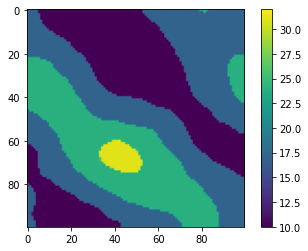

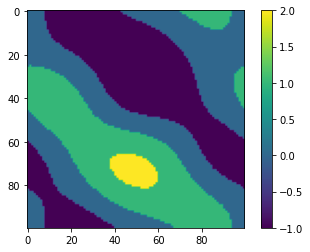

In [191]:
plt.imshow( np.rot90(np.flipud(PredictedVx)) )
plt.colorbar()
plt.show()

plt.imshow( Vx )
plt.colorbar()
plt.show()